In [3]:

%load_ext autoreload
%autoreload 2
from torch import device
from abc import ABC
import warnings
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from dataset.signal_dataset import SignalDataset
from sklearn.metrics import classification_report
import re
from pathlib import Path
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y
import yaml
import re
import librosa
from pathlib import Path
import abc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.fft import fft
import yaml
from typing import Callable
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
import seaborn as sns
import networks
import tsaug
import torchaudio.transforms as T
import torchaudio
from IPython.display import Audio
from matplotlib.patches import Rectangle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sample_rate = 1562500
channel_1 = 'ch1'
channel_2 = 'ch2'
channel_3 = 'ch3'
signal_data_dir = "/mnt/home2/Motor_project/AE_PETR_loziska/"
ch1_config = [{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_1 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_1 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
ch2_config = [{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_2 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_2 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
ch3_config = [{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_3 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_3 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
    
noise_config = {"intensity": 1,
                "bin_path": Path("/mnt/home2/Motor_project/AE_PETR_loziska/prevodovka/AE-DATA-conti-7394086655261458-ch1.bin")}



In [5]:
ch1_set = SignalDataset(step=10000, window_size=5000, bin_setup=ch1_config, device="cpu", source_dtype="float32")
ch2_set = SignalDataset(step=10000, window_size=5000, bin_setup=ch2_config, device="cpu", source_dtype="float32")
ch3_set = SignalDataset(step=10000, window_size=5000, bin_setup=ch3_config, device="cpu", source_dtype="float32")

ch1_with_noise = SignalDataset(step=10000, window_size=10000, bin_setup=ch1_config, noise = noise_config, source_dtype="float32")

In [6]:
def frequency_shift(signal, fs, max_shift_hz):

    frequency_shift_hz = np.random.uniform(-max_shift_hz, max_shift_hz)

    # Perform FFT
    n = len(signal)
    fft_signal = np.fft.fft(signal)

    # Frequency axis
    freqs = np.fft.fftfreq(n, 1/fs)

    # Frequency shift
    shift_phase = np.exp(1j * 2 * np.pi * frequency_shift_hz * freqs)

    # Apply frequency shift
    shifted_fft_signal = fft_signal * shift_phase

    # Inverse FFT to get the time-domain signal
    shifted_signal = np.fft.ifft(shifted_fft_signal)

    # Ensure real output by taking real part (due to potential numerical noise)
    shifted_signal = np.real(shifted_signal)

    return shifted_signal

In [33]:
signal = ch1_set[0][0].reshape(-1)
shifted = frequency_shift(signal, sample_rate, sample_rate//10)

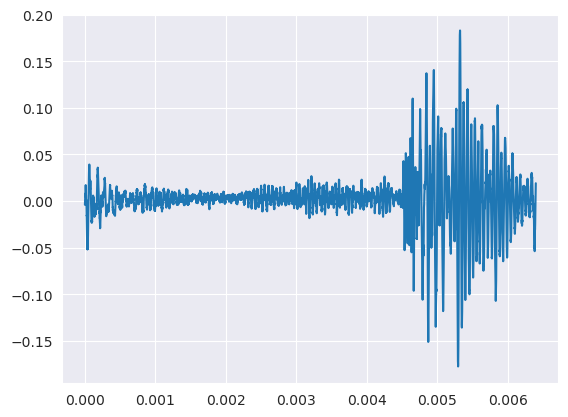

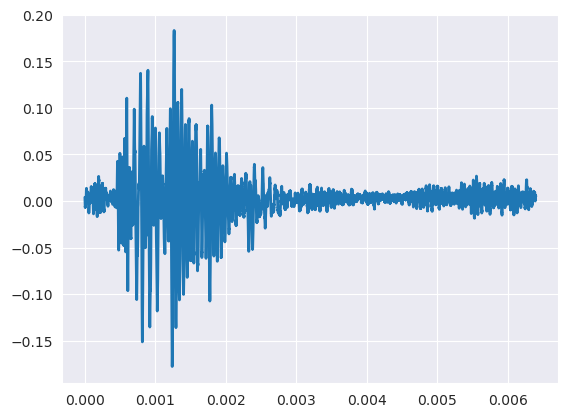

In [34]:
duration = 10000 / sample_rate  # seconds
time = np.linspace(0, duration, 10000, endpoint=False)
plt.plot(time, signal, label='Signal')
plt.show()
plt.plot(time, shifted, label='shifted', linewidth=2)
plt.show()

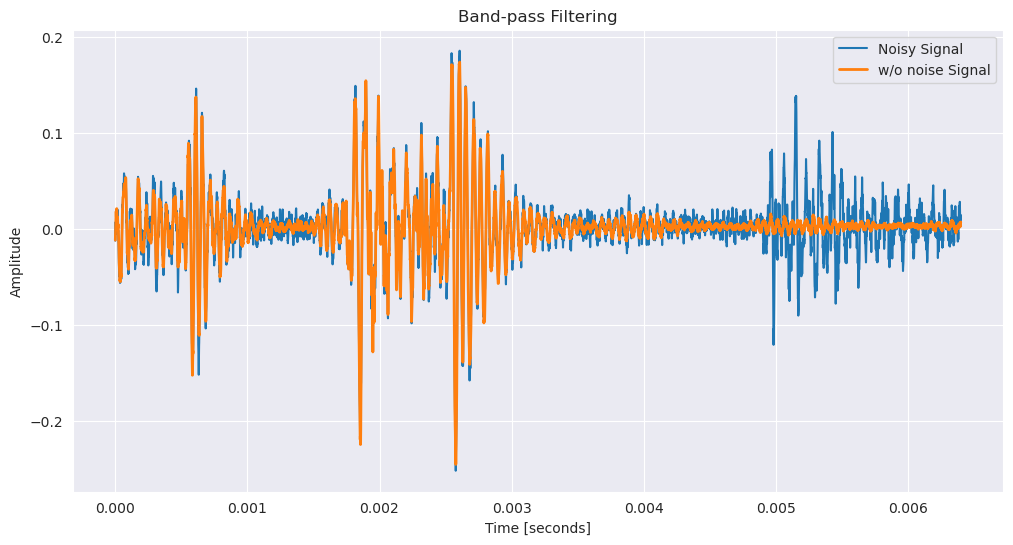

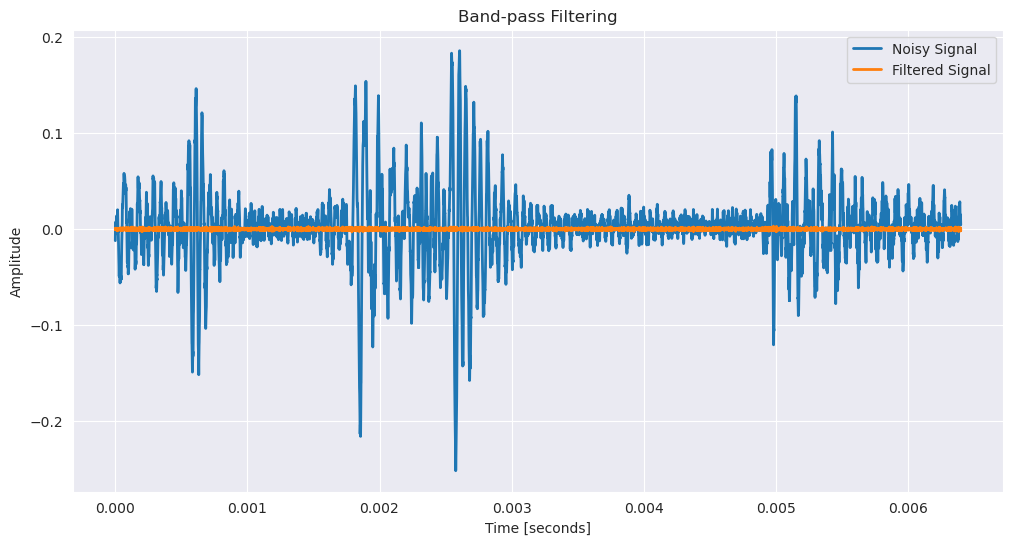

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Generate example ultrasound time series data with 10,000 samples
np.random.seed(0)
sample_rate = 1562500  # 1.5625 MHz
duration = 10000 / sample_rate  # seconds
time = np.linspace(0, duration, 10000, endpoint=False)
frequency = 500000  # 500 kHz, typical ultrasound frequency
data = ch1_with_noise[500][0].reshape(-1)
data2 = ch1_set[500][0].reshape(-1)
# Design a Butterworth band-pass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply band-pass filter
lowcut = 400000  # 400 kHz
highcut = 700000  # 600 kHz
filtered_data = butter_bandpass_filter(data, lowcut, highcut, sample_rate)

# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Noisy Signal')

plt.plot(time, data2, label='w/o noise Signal', linewidth=2)
# plt.plot(time, filtered_data, label='Filtered Signal', linewidth=2)

plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Band-pass Filtering')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Noisy Signal', linewidth=2)

# plt.plot(time, data2, label='wo noise Signal', linewidth=2)
plt.plot(time, filtered_data, label='Filtered Signal', linewidth=2)

plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Band-pass Filtering')
plt.show()

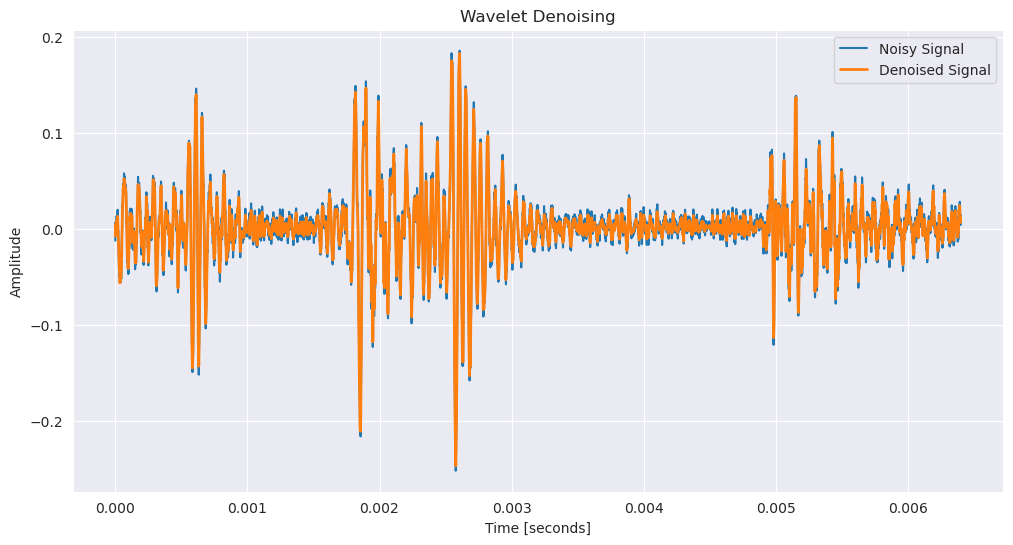

In [12]:
import pywt

# Function to perform wavelet denoising
def wavelet_denoising(data, wavelet='coif12', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745 * np.sqrt(2 * np.log(len(data)))
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(denoised_coeffs, wavelet)

# Apply wavelet denoising
denoised_data = wavelet_denoising(data)

# Plot original and denoised signals
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Noisy Signal')
plt.plot(time, denoised_data, label='Denoised Signal', linewidth=2)
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Wavelet Denoising')
plt.show()

/tmp/ipykernel_78275/1652153805.py:89: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


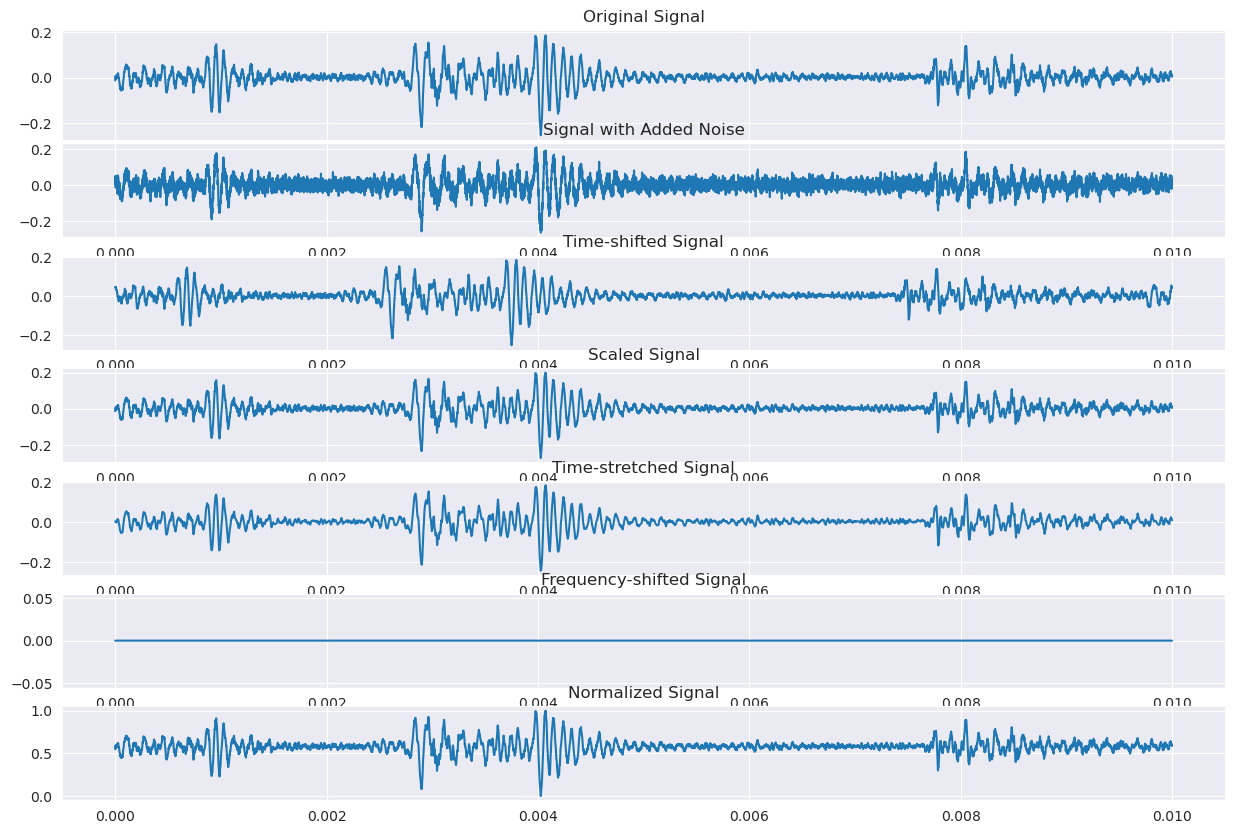

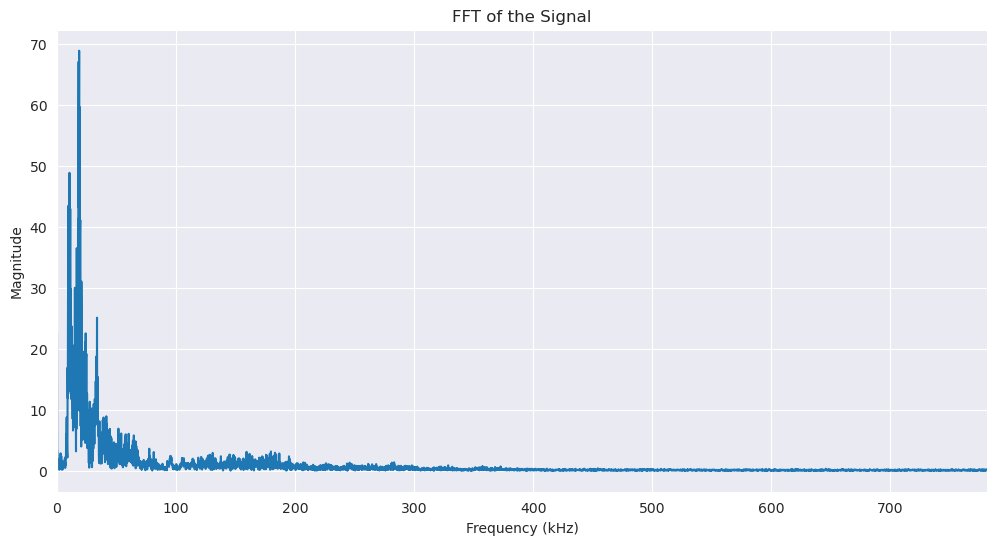

In [15]:
# Generate example time series data with 10,000 samples
np.random.seed(0)
sample_rate = 1562500  # 1.5625 MHz
duration = 10000 / sample_rate  # seconds
time = np.linspace(0, duration, 10000, endpoint=False)
frequency = 500000  # 500 kHz, typical ultrasound frequency
signal = data

# Perform FFT
fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), 1/sample_rate)

# Take the magnitude of the FFT and only keep the positive frequencies
fft_magnitude = np.abs(fft_result)[:len(signal) // 2]
fft_freq = fft_freq[:len(signal) // 2]

# Plot the FFT results
plt.figure(figsize=(12, 6))
plt.plot(fft_freq / 1000, fft_magnitude)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude')
plt.title('FFT of the Signal')
plt.grid(True)
plt.xlim(0, sample_rate / 2000)  # Limit frequency axis to Nyquist frequency in kHz
plt.show()